In [22]:
import os, json, glob, shutil, re, random
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
import nltk


In [10]:
!pip install textstat
from textstat import flesch_reading_ease, flesch_kincaid_grade, smog_index

nltk.download('punkt')
nltk.download('stopwords')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.5 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# Clone the official M3 dataset repository
!git clone https://github.com/julia-nixie/m3.git /content/m3_repo


repo_root = "/content/m3_repo"
print("Repo root:", repo_root)
print("Top-level files:", os.listdir(repo_root))
print("JSONL files:", glob.glob(repo_root + "/*.jsonl"))
print("ZIP files:", glob.glob(repo_root + "/*.zip"))


fatal: destination path '/content/m3_repo' already exists and is not an empty directory.
Repo root: /content/m3_repo
Top-level files: ['.git', 'unprocessed2.zip', 'README.md', 'unprocessed1.zip', 'level2.jsonl', 'level1.jsonl', 'level3.jsonl']
JSONL files: ['/content/m3_repo/level2.jsonl', '/content/m3_repo/level1.jsonl', '/content/m3_repo/level3.jsonl']
ZIP files: ['/content/m3_repo/unprocessed2.zip', '/content/m3_repo/unprocessed1.zip']


In [12]:
# Copy the JSONL files into the project folder and list them


# Create project data folders
os.makedirs("/content/m3/raw", exist_ok=True)
os.makedirs("/content/m3/processed", exist_ok=True)

# Copy structured files level1/2/3 into /content/m3/raw
for p in glob.glob("/content/m3_repo/level*.jsonl"):
    shutil.copy2(p, "/content/m3/raw/")

# Verify
print("Files now in /content/m3/raw:")
print(os.listdir("/content/m3/raw"))


Files now in /content/m3/raw:
['level2.jsonl', 'level1.jsonl', 'level3.jsonl']


In [35]:
# Preview sample records from each level
levels = ["level1", "level2", "level3"]

for lvl in levels:
    path = f"/content/m3/raw/{lvl}.jsonl"
    print(f"\nPreviewing {lvl}:")
    with open(path, "r", encoding="utf-8") as f:
        for i in range(2):  # show first two records
            rec = json.loads(f.readline())
            print(f"Record {i+1} keys:", list(rec.keys()))
            print(f"Target text (first 120 chars): {rec['target_text'][:120]}")


Previewing level1:
Record 1 keys: ['docid', 'target_text', 'input_text', 'input_studies']
Target text (first 120 chars): CONCLUSION: This analysis provides a current evidence-based estimate of PACG prevalence in European derived populations 
Record 2 keys: ['docid', 'target_text', 'input_text', 'input_studies']
Target text (first 120 chars): CONCLUSIONS: Current data suggests that IVB is an effective short-term treatment for diabetic macular edema, and that it

Previewing level2:
Record 1 keys: ['docid', 'target_text', 'input_text', 'input_studies']
Target text (first 120 chars): The result of this meta-analysis suggested a statistically significant association between H. pylori infection and OAG.
Record 2 keys: ['docid', 'target_text', 'input_text', 'input_studies']
Target text (first 120 chars): Further analysis showed that this positive relation is observed only in POAG and NTG patients, but not in the PXFG patie

Previewing level3:
Record 1 keys: ['docid', 'pico', 'discourse_relat

## Exploratory Data Analysis (EDA)

,Level,n_records,avg_input_words,avg_target_words
0,Level 1,451,3634.053215,49.891353
1,Level 2,315,166.558730,24.038095
2,Level 3,381,125.181102,23.860892


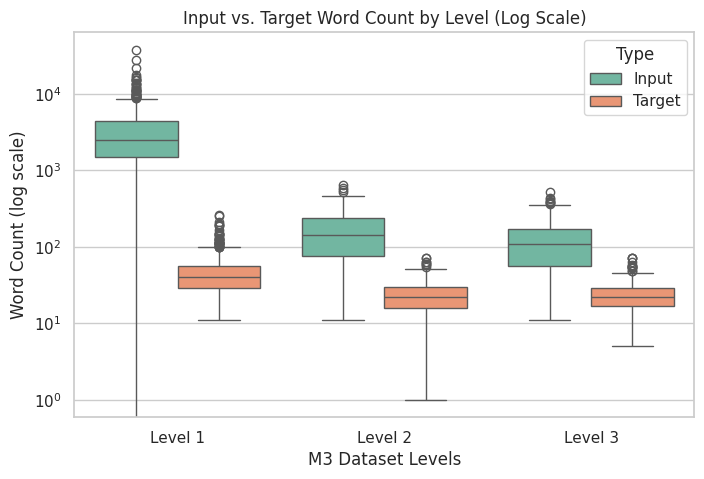

In [26]:
sns.set(style="whitegrid")

# Compute average word counts per level
levels = ["level1_clean", "level2_clean", "level3_clean"]
summary_stats, plot_data = [], []

for lvl in levels:
    path = f"/content/m3/processed/{lvl}.jsonl"
    granularity = lvl.split("_")[0].replace("level", "Level ")
    input_lens, target_lens = [], []

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            rec = json.loads(line)
            i_len = len(rec["input_text"].split())
            t_len = len(rec["target_text"].split())
            input_lens.append(i_len)
            target_lens.append(t_len)
            plot_data.append({"Level": granularity, "Type": "Input", "Words": i_len})
            plot_data.append({"Level": granularity, "Type": "Target", "Words": t_len})

    summary_stats.append({
        "Level": granularity,
        "n_records": len(input_lens),
        "avg_input_words": np.mean(input_lens),
        "avg_target_words": np.mean(target_lens)
    })

df_stats = pd.DataFrame(summary_stats)
display(df_stats)


df_plot = pd.DataFrame(plot_data)
plt.figure(figsize=(8,5))
sns.boxplot(data=df_plot, x="Level", y="Words", hue="Type", palette="Set2")
plt.yscale("log")
plt.title("Input vs. Target Word Count by Level (Log Scale)")
plt.ylabel("Word Count (log scale)")
plt.xlabel("M3 Dataset Levels")
plt.show()


Level 1 (document-level) has the longest inputs (~3600 words) and full multi-document summaries.

Level 2 and 3 progressively narrow the scope to sentences and individual claims (~24 words).

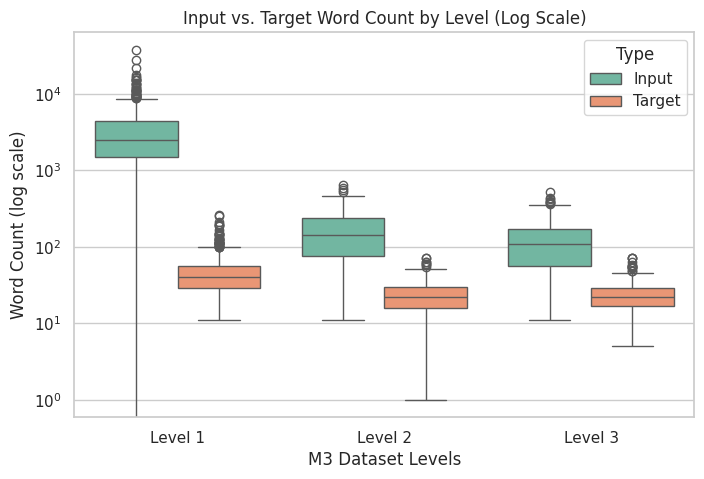

In [25]:
# Word Count Distributions by Level:

sns.set(style="whitegrid")

levels = ["level1_clean", "level2_clean", "level3_clean"]
data = []

for lvl in levels:
    path = f"/content/m3/processed/{lvl}.jsonl"
    granularity = lvl.split("_")[0].replace("level", "Level ")
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            rec = json.loads(line)
            input_len = len(rec["input_text"].split())
            target_len = len(rec["target_text"].split())
            data.append({"Level": granularity, "Type": "Input", "Words": input_len})
            data.append({"Level": granularity, "Type": "Target", "Words": target_len})


df = pd.DataFrame(data)

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="Level", y="Words", hue="Type", palette="Set2")
plt.yscale("log")
plt.title("Input vs. Target Word Count by Level (Log Scale)")
plt.ylabel("Word Count (log scale)")
plt.xlabel("M3 Dataset Levels")
plt.show()



,Level,avg_FRE,avg_FKGL,avg_SMOG
0,Level 1,21.283021,15.562644,16.762802
1,Level 2,24.127514,15.100008,16.119341
2,Level 3,23.102099,15.561667,16.452587


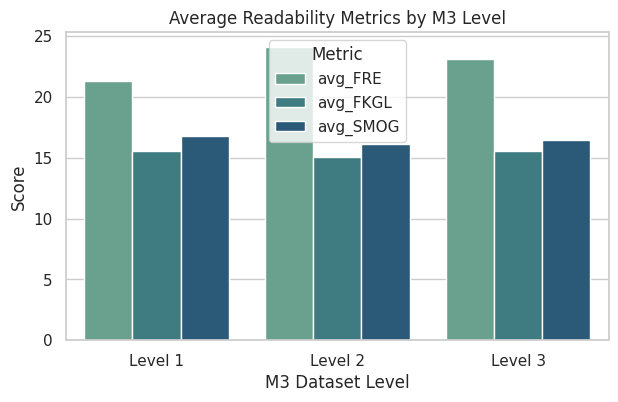

In [27]:
sns.set(style="whitegrid")

# Compute readability metrics
levels = ["level1_clean", "level2_clean", "level3_clean"]
rows = []

for lvl in levels:
    path = f"/content/m3/processed/{lvl}.jsonl"
    granularity = lvl.split("_")[0].replace("level", "Level ")
    fre, fkgl, smog = [], [], []

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            rec = json.loads(line)
            text = rec["target_text"]
            if len(text.split()) < 10:
                continue
            fre.append(flesch_reading_ease(text))
            fkgl.append(flesch_kincaid_grade(text))
            smog.append(smog_index(text))

    rows.append({
        "Level": granularity,
        "avg_FRE": np.mean(fre),
        "avg_FKGL": np.mean(fkgl),
        "avg_SMOG": np.mean(smog)
    })

df_read = pd.DataFrame(rows)
display(df_read)


df_melt = df_read.melt(id_vars="Level", var_name="Metric", value_name="Score")
plt.figure(figsize=(7,4))
sns.barplot(data=df_melt, x="Level", y="Score", hue="Metric", palette="crest")
plt.title("Average Readability Metrics by M3 Level")
plt.ylabel("Score")
plt.xlabel("M3 Dataset Level")
plt.legend(title="Metric")
plt.show()


All three M3 levels show high text complexity, with FKGL and SMOG around 15–16 and low FRE scores near 22. This means the dataset is uniformly difficult, typical of scientific language. Level 2 is slightly easier, but overall, differences reflect summarization detail—not audience readability.


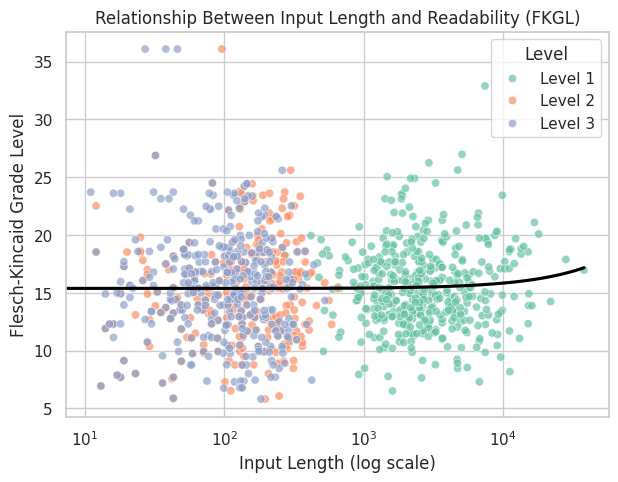

Pearson correlation by level:
  Level 1: 0.046
  Level 2: 0.074
  Level 3: -0.103


In [28]:
# Input Length vs. Readability (FKGL)
rows = []
levels = ["level1_clean", "level2_clean", "level3_clean"]

for lvl in levels:
    path = f"/content/m3/processed/{lvl}.jsonl"
    granularity = lvl.split("_")[0].replace("level", "Level ")
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            rec = json.loads(line)
            text = rec["target_text"]
            if len(text.split()) < 10:
                continue
            rows.append({
                "Level": granularity,
                "Input_len": len(rec["input_text"].split()),
                "FKGL": flesch_kincaid_grade(text)
            })

df_corr = pd.DataFrame(rows)

# correlation plot
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_corr, x="Input_len", y="FKGL", hue="Level", alpha=0.7, palette="Set2")
sns.regplot(data=df_corr, x="Input_len", y="FKGL", scatter=False, color="black", ci=None)
plt.xscale("log")
plt.title("Relationship Between Input Length and Readability (FKGL)")
plt.xlabel("Input Length (log scale)")
plt.ylabel("Flesch-Kincaid Grade Level")
plt.show()

# Correlation coefficients
print("Pearson correlation by level:")
for lvl, sub in df_corr.groupby("Level"):
    corr = sub["Input_len"].corr(sub["FKGL"])
    print(f"  {lvl}: {corr:.3f}")


The scatter plot shows almost no correlation between input length and readability across all M3 levels. The Pearson values (0.046 for Level 1, 0.074 for Level 2 and –0.103 for Level 3) are close to zero, indicating that longer biomedical texts are not necessarily harder to read. This suggests that text complexity in M3 is driven more by scientific language and terminology than by input size.


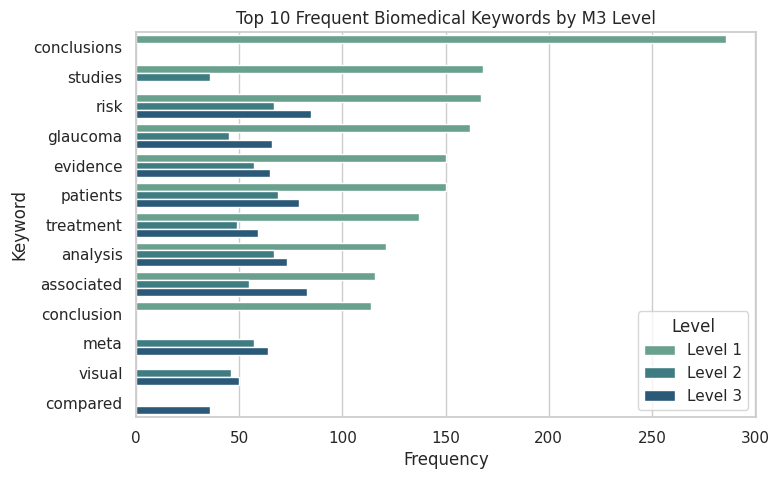

In [29]:
# Top Biomedical Keywords by Level:

stops = set(stopwords.words("english"))
levels = ["level1_clean", "level2_clean", "level3_clean"]
keywords = []

def extract_words(text):
    words = re.findall(r"[A-Za-z]+", text.lower())
    return [w for w in words if w not in stops and len(w) > 3]

for lvl in levels:
    path = f"/content/m3/processed/{lvl}.jsonl"
    granularity = lvl.split("_")[0].replace("level", "Level ")
    with open(path, "r", encoding="utf-8") as f:
        tokens = []
        for i, line in enumerate(f):
            rec = json.loads(line)
            tokens.extend(extract_words(rec["target_text"]))
        top = Counter(tokens).most_common(10)
        for w, c in top:
            keywords.append({"Level": granularity, "Word": w, "Count": c})

df_kw = pd.DataFrame(keywords)

plt.figure(figsize=(8,5))
sns.barplot(data=df_kw, x="Count", y="Word", hue="Level", orient="h", palette="crest")
plt.title("Top 10 Frequent Biomedical Keywords by M3 Level")
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.show()


## Cleaning and Normalization

In [17]:
# Ensure punctuation, spacing, and symbols are standardized (so tokenization later won’t break).

def clean_text(text):
    text = re.sub(r"\s+", " ", text)                  # collapse multiple spaces
    text = text.replace("’", "'").replace("–", "-")   # normalize quotes/dashes
    text = re.sub(r"[“”]", '"', text)                 # normalize double quotes
    text = re.sub(r"\s([?.!,;:])", r"\1", text)       # remove space before punctuation
    text = text.strip()
    return text

levels = ["level1", "level2", "level3"]

for lvl in levels:
    in_path = f"/content/m3/raw/{lvl}.jsonl"
    out_path = f"/content/m3/processed/{lvl}_clean.jsonl"

    with open(in_path, "r", encoding="utf-8") as fin, open(out_path, "w", encoding="utf-8") as fout:
        for line in fin:
            rec = json.loads(line)
            rec["target_text"] = clean_text(rec["target_text"])
            rec["input_text"]  = clean_text(rec["input_text"])
            fout.write(json.dumps(rec) + "\n")

print("Cleaned files saved to /content/m3/processed/")
print(os.listdir("/content/m3/processed"))


Cleaned files saved to /content/m3/processed/
['level2_clean.jsonl', 'level3_clean.jsonl', 'level1_clean.jsonl']


In [20]:
# Align and Split for Fine-Tuning
# Prepare the data for model training by creating input-target pairs and splitting into training and validation sets.

from sklearn.model_selection import train_test_split

random.seed(42)
pairs = []

# Use Level 1 (document-level) for summarization fine-tuning
path = "/content/m3/processed/level1_clean.jsonl"
with open(path, "r", encoding="utf-8") as f:
    for line in f:
        rec = json.loads(line)
        pairs.append({
            "input_text": rec["input_text"],
            "target_text": rec["target_text"]
        })

# Split into train/validation
train_pairs, val_pairs = train_test_split(pairs, test_size=0.15, random_state=42)

# Save
os.makedirs("/content/m3/aligned", exist_ok=True)
with open("/content/m3/aligned/train.jsonl", "w", encoding="utf-8") as f:
    for p in train_pairs:
        f.write(json.dumps(p) + "\n")

with open("/content/m3/aligned/val.jsonl", "w", encoding="utf-8") as f:
    for p in val_pairs:
        f.write(json.dumps(p) + "\n")

print(f"Train size: {len(train_pairs)},  Validation size: {len(val_pairs)}")
print("Files saved to /content/m3/aligned/")


Train size: 383,  Validation size: 68
Files saved to /content/m3/aligned/


We combined Levels 1 (document), 2 (sentence), and 3 (claim) to increase the dataset size and expose the model to multiple granularities of summarization. This allows the fine-tuned BART model to learn both broad, multi-document summaries and concise, evidence-level claims, improving generalization across biomedical text structures.

In [21]:
# Combining All M3 Levels for Unified Biomedical Summarization
from collections import Counter
from sklearn.model_selection import train_test_split

os.makedirs("/content/m3/aligned", exist_ok=True)

def load_pairs(path, granularity):
    out = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            rec = json.loads(line)
            inp = f"<LEVEL:{granularity}> " + rec["input_text"]
            tgt = rec["target_text"]
            out.append({"input_text": inp, "target_text": tgt, "granularity": granularity})
    return out

l1 = load_pairs("/content/m3/processed/level1_clean.jsonl", "DOC")
l2 = load_pairs("/content/m3/processed/level2_clean.jsonl", "SENT")
l3 = load_pairs("/content/m3/processed/level3_clean.jsonl", "CLAIM")

all_pairs = l1 + l2 + l3
y = [p["granularity"] for p in all_pairs]
print("Total examples:", len(all_pairs))
print("Counts overall:", Counter(y))

train, val = train_test_split(all_pairs, test_size=0.15, random_state=42, stratify=y)

with open("/content/m3/aligned/all_train.jsonl", "w", encoding="utf-8") as f:
    for p in train: f.write(json.dumps(p) + "\n")
with open("/content/m3/aligned/all_val.jsonl", "w", encoding="utf-8") as f:
    for p in val: f.write(json.dumps(p) + "\n")

print(f"Train size: {len(train)}, Val size: {len(val)}")
from collections import Counter
print("Train by level:", Counter(p["granularity"] for p in train))
print("Val by level:  ", Counter(p["granularity"] for p in val))


Total examples: 1147
Counts overall: Counter({'DOC': 451, 'CLAIM': 381, 'SENT': 315})
Train size: 974, Val size: 173
Train by level: Counter({'DOC': 383, 'CLAIM': 324, 'SENT': 267})
Val by level:   Counter({'DOC': 68, 'CLAIM': 57, 'SENT': 48})
